In [349]:
from pyspark import SparkContext 
from pyspark.sql import SQLContext 
import pandas as pd
import numpy as np
from pandas import DataFrame
# sc = SparkContext.getOrCreate()
# sqlc=SQLContext(sc)

import math
import matplotlib.pyplot as plt
from scipy.stats import norm, entropy 
from scipy.stats import probplot
import matplotlib.pyplot as plt
from scipy.stats import logistic
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.utils import resample
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from scipy.spatial.distance import cosine, correlation
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import Perceptron

In [350]:
#reading csv file data in a dataframe
#[1]https://stackoverflow.com/questions/46311133/creating-dynamic-data-frames-in-python?rq=1
df_names=['df07','df08','df09','df10','df11','df12','df13','df14','df15','df16','df17','df18']
years=['2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018']
d = {}
for name,i in zip(df_names,years):
    d[name] = pd.DataFrame()
    d[name]=pd.read_csv('data-csv/chs'+str(i)+'_public.csv')    


In [351]:
# df=df18.copy()
df=d['df18']
df.head()

,qxvers,mood63,mood64,mood54,mood55,mood56,mood57,mood58,mood59,mood61,...,heavydrink18,bingenew,ipvphy,insultipv,wt_compare,strata,strata_q1,bthcntrltype18,hhsize,child
0,2,2.0,2.0,1.0,2.0,2.0,1.0,1.0,1.0,NaN,...,2.0,2.0,2.0,2.0,386.743729,2018030,NaN,NaN,2,2.0
1,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,...,2.0,2.0,2.0,2.0,1634.654991,2018031,2018031.0,2.0,4,1.0
2,2,NaN,1.0,3.0,3.0,1.0,1.0,2.0,2.0,NaN,...,2.0,1.0,1.0,1.0,3073.304927,2018039,NaN,1.0,6,1.0
3,2,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,NaN,...,2.0,1.0,2.0,2.0,1384.557358,2018006,NaN,NaN,4,1.0
4,1,3.0,1.0,4.0,2.0,1.0,2.0,1.0,1.0,NaN,...,2.0,2.0,2.0,2.0,272.506653,2018029,2018029.0,NaN,1,2.0


In [85]:
#number of features
len(df.columns)

149

In [86]:
df.columns

Index(['qxvers', 'mood63', 'mood64', 'mood54', 'mood55', 'mood56', 'mood57',
       'mood58', 'mood59', 'mood61',
       ...
       'heavydrink18', 'bingenew', 'ipvphy', 'insultipv', 'wt_compare',
       'strata', 'strata_q1', 'bthcntrltype18', 'hhsize', 'child'],
      dtype='object', length=149)

In [87]:
#number of rows
len(df["qxvers"])

10076

In [88]:
df.isnull().sum()

qxvers               0
mood63             233
mood64             147
mood54             134
mood55             159
                  ... 
strata               0
strata_q1         5053
bthcntrltype18    6303
hhsize               0
child               50
Length: 149, dtype: int64

qxvers-Questionnaire version
nutrition46-cupsof fruit
nutrition47-cups of vegetable

# Steps followed for analysis
#process NA values
#find correlation between target and source variables and perform dimensionality reduction
#divide data into training and test sets
#apply regression
#reduce parameters depending upon correlartion
#apply regression again and compare models

In [89]:
#correlation function
#[1]https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec
#[2]https://seaborn.pydata.org/examples/many_pairwise_correlations.html
def draw_corr(corr_var):
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr_var, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    ax = sns.heatmap(
        corr_var, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True,
        mask=mask,
#         annot=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    );

# Checking correlation between physical activity data

In [90]:
df_train_physical=df[["cid","exercise18","cyclingfreq","cycling18","imputed_PA08_3R_q1","generalhealth"]]

In [91]:
df_train_physical.isnull().sum()

cid                      0
exercise18              21
cyclingfreq             26
cycling18               26
imputed_PA08_3R_q1    5053
generalhealth           46
dtype: int64

In [92]:
#since imputed_PA08_3R_q1 has 5000+ values as N/A we will drop this column
df_train_physical=df_train_physical[["cid","exercise18","cyclingfreq","cycling18","generalhealth"]]
df_train_physical.head()

,cid,exercise18,cyclingfreq,cycling18,generalhealth
0,1900001,1.0,2.0,1.0,2.0
1,1900002,1.0,5.0,5.0,2.0
2,1900003,1.0,5.0,5.0,4.0
3,1900004,1.0,5.0,5.0,2.0
4,1900005,2.0,2.0,1.0,3.0


In [93]:
#dropping NaN values
df_train_physical=df_train_physical.dropna()
df_train_physical.head()

,cid,exercise18,cyclingfreq,cycling18,generalhealth
0,1900001,1.0,2.0,1.0,2.0
1,1900002,1.0,5.0,5.0,2.0
2,1900003,1.0,5.0,5.0,4.0
3,1900004,1.0,5.0,5.0,2.0
4,1900005,2.0,2.0,1.0,3.0


In [94]:
#correlation
#[1]https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec
corr_1 = df_train_physical.corr()
corr_1

,cid,exercise18,cyclingfreq,cycling18,generalhealth
cid,1.000000,-0.039525,-0.128924,-0.132294,-0.102162
exercise18,-0.039525,1.000000,0.160250,0.158063,0.198179
cyclingfreq,-0.128924,0.160250,1.000000,0.953135,0.179920
cycling18,-0.132294,0.158063,0.953135,1.000000,0.173137
generalhealth,-0.102162,0.198179,0.179920,0.173137,1.000000


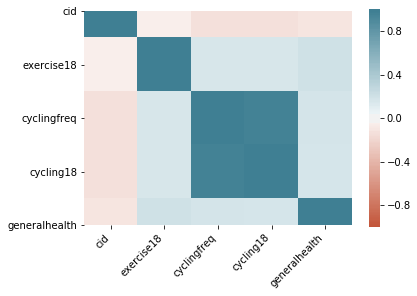

In [95]:
ax = sns.heatmap(
    corr_1, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

#we see that cyclingfreq and cycling18 are highly correlated, so we can remove one of them. We remove cycling18 as it is less relevent out of the two for our analysis

In [96]:
df_train_physical=df_train_physical[["cid","exercise18","cyclingfreq","generalhealth"]]
df_train_physical.head()

,cid,exercise18,cyclingfreq,generalhealth
0,1900001,1.0,2.0,2.0
1,1900002,1.0,5.0,2.0
2,1900003,1.0,5.0,4.0
3,1900004,1.0,5.0,2.0
4,1900005,2.0,2.0,3.0


               exercise18  cyclingfreq  generalhealth
exercise18       1.000000      0.16025       0.198179
cyclingfreq      0.160250      1.00000       0.179920
generalhealth    0.198179      0.17992       1.000000


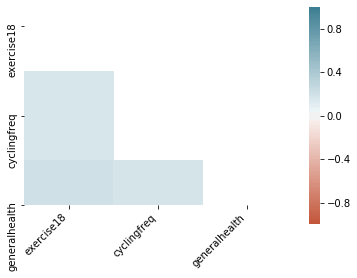

In [97]:
corr_2 = df_train_physical[["exercise18","cyclingfreq","generalhealth"]].corr()
draw_corr(corr_2)
print(corr_2)
#All have positive correlation. exercise18 is most correlated to general health

# Checking correlation between Nutrition data

In [98]:
df_train_nutrition = df[["nutrition46","nutrition47","fruitveg18",
                         "nsodaperday18","avgsodaperday18","twoplussoda",
                         "nsugardrinkperday18","avgsugarperday18","nsodasugarperday18",
                         "avgsodasugarperday18","ssb",
                         "generalhealth"]]
print(df_train_nutrition.head())
df_train_nutrition.isnull().sum()


   nutrition46  nutrition47  fruitveg18  nsodaperday18  avgsodaperday18  \
0          2.0          1.0         2.0       0.000000              1.0   
1          1.0          1.0         2.0       1.000000              3.0   
2          1.0          2.0         2.0       0.066116              2.0   
3          1.0          1.0         2.0       0.000000              1.0   
4          0.0          2.0         2.0       0.000000              1.0   

   twoplussoda  nsugardrinkperday18  avgsugarperday18  nsodasugarperday18  \
0          2.0             0.000000               1.0            0.000000   
1          2.0             0.285714               2.0            1.285714   
2          2.0             0.000000               1.0            0.066116   
3          2.0             0.000000               1.0            0.000000   
4          2.0             0.000000               1.0            0.000000   

   avgsodasugarperday18  ssb  generalhealth  
0                   1.0  2.0            

nutrition46             186
nutrition47             233
fruitveg18              345
nsodaperday18            84
avgsodaperday18          84
twoplussoda              84
nsugardrinkperday18     119
avgsugarperday18        119
nsodasugarperday18      115
avgsodasugarperday18    115
ssb                     115
generalhealth            46
dtype: int64

generalhealth         avgsodaperday18     0.010964
avgsodaperday18       generalhealth       0.010964
avgsugarperday18      generalhealth       0.013917
generalhealth         avgsugarperday18    0.013917
avgsodasugarperday18  generalhealth       0.023976
                                            ...   
nsodaperday18         nsodaperday18       1.000000
fruitveg18            fruitveg18          1.000000
nutrition47           nutrition47         1.000000
ssb                   ssb                 1.000000
generalhealth         generalhealth       1.000000
Length: 144, dtype: float64

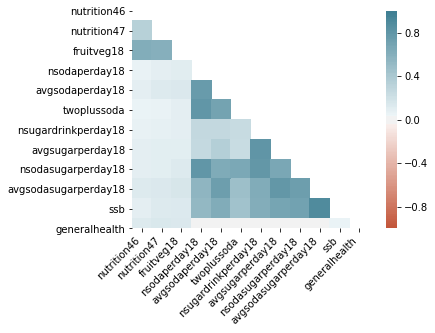

In [99]:
#[1]https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas

df_train_nutrition=df_train_nutrition.dropna()
corr_3 = df_train_nutrition.corr().abs()
draw_corr(corr_3)

corr_3.unstack().sort_values(kind="quicksort")


avgsodaperday18   generalhealth       0.010964
generalhealth     avgsodaperday18     0.010964
avgsugarperday18  generalhealth       0.013917
generalhealth     avgsugarperday18    0.013917
ssb               generalhealth       0.048220
generalhealth     ssb                 0.048220
nutrition46       avgsugarperday18    0.088759
avgsugarperday18  nutrition46         0.088759
nutrition46       ssb                 0.097717
ssb               nutrition46         0.097717
avgsodaperday18   nutrition46         0.101538
nutrition46       avgsodaperday18     0.101538
nutrition47       avgsugarperday18    0.106579
avgsugarperday18  nutrition47         0.106579
generalhealth     nutrition46         0.119109
nutrition46       generalhealth       0.119109
nutrition47       ssb                 0.121579
ssb               nutrition47         0.121579
avgsodaperday18   nutrition47         0.126284
nutrition47       avgsodaperday18     0.126284
                  generalhealth       0.151396
generalhealth

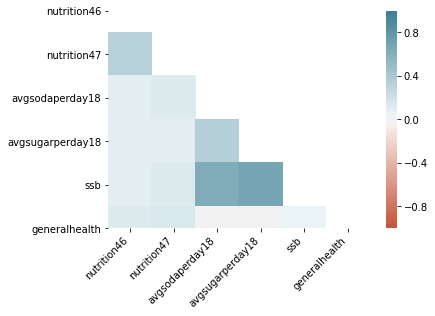

In [100]:
# features dropped pertaining to high correlation with other features :  
df_train_nutrition = df_train_nutrition[["nutrition46","nutrition47"
                        ,"avgsodaperday18"
                        ,"avgsugarperday18"
                         ,"ssb"
                         ,"generalhealth"]]

#finding correlation in remaining features
corr_nutrition = df_train_nutrition.corr().abs()
draw_corr(corr_nutrition)
corr_nutrition.unstack().sort_values(kind="quicksort")


#Next most correlated columns after deleting the previous coulmns:

nutrition47       fruitveg18          0.597664
fruitveg18        nutrition46         0.624137
avgsodaperday18   ssb                 0.626788

ssb               avgsugarperday18   -0.687271

One analysis we would do without further elimination to see how the target variable fares. ssb is correlated to both avgsodaperday18 and avgsugarperday18. We will keep ssb as it combines both soda and other drinks consumed by an individual. Also nutrition47 and fruitveg18 are correlated. Lets keep them for now as corelation is not very strong.

In [101]:
# features dropped pertaining to high correlation with other features :  
df_train_nutrition = df_train_nutrition[["nutrition46","nutrition47"
                         ,"ssb"
                         ,"generalhealth"]]

# Making prediction and checking rmse

In [348]:
#[1]https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
#[2]https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
from sklearn.random_projection import sparse_random_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error
from math import sqrt

#function for rmse calculation of model
def model_apply(x,y,algo,n):
    x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25,random_state=0)
    scaler = StandardScaler()
    # Fit on training set only.
    scaler.fit(x_train)
    # Apply transform to both the training set and the test set.
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)
    
    pca = PCA(n_components=n,tol=.95)
    pca.fit(x_test)
    print(pca.explained_variance_ratio_) 
    
    x_train = pca.transform(x_train)
    x_test = pca.transform(x_test)
    
#     principalDf = pd.DataFrame(data = x_train
#              , columns = ['pc1', 'pc2','pc3'])
#     print(principalDf)

    #model selection
    if algo==1:
        model=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial',max_iter=200)
    elif algo==2:
        model=GaussianNB()
    elif algo==3:
        model=DecisionTreeClassifier()
    elif algo==4:
        model=svm.SVC(gamma='scale')
    elif algo==5:
        model=Perceptron(tol=1e-3, random_state=0)
        
        # Train the model using the training sets
    model.fit(x_train,y_train.values.ravel())

    # Predict Output
    y_pred = model.predict(x_test)
    print ("Predicted Value:", y_pred)
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    return(rmse)

# Physical Activity vs General Health

In [134]:
#preparing training and test data
x=df_train_physical[["exercise18","cyclingfreq"]] #source feature
y=df_train_physical[["generalhealth"]] #target feature
# algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=1.1530 DT= 1.1400
# model = GaussianNB() #rmse=1.28

In [141]:
model_apply(x,y,3,2)

[0.57708118 0.42291882]
Predicted Value: [3. 3. 3. ... 3. 3. 3.]
Accuracy: 0.3223868642370845
[[  0  98 317   0   0]
 [  0 138 513   1   0]
 [  0  97 658   2   0]
 [  0  40 467   9   0]
 [  0   5 146   6   0]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       415
         2.0       0.37      0.21      0.27       652
         3.0       0.31      0.87      0.46       757
         4.0       0.50      0.02      0.03       516
         5.0       0.00      0.00      0.00       157

    accuracy                           0.32      2497
   macro avg       0.24      0.22      0.15      2497
weighted avg       0.29      0.32      0.22      2497



/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


1.1398065584953205

# Nutrition vs General Health

In [344]:
#preparing training and test data
x=df_train_nutrition[["nutrition46","nutrition47","ssb"]] #source feature
y=df_train_nutrition[["generalhealth"]] #target feature
# algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=1.1343 DT=1.1685
# model = GaussianNB() #rmse=1.28
model_apply(x,y,3,1)

[0.4619264]
Predicted Value: [3. 3. 3. ... 1. 2. 3.]
Accuracy: 0.32607785684386775
[[  6 135 233   5   0]
 [ 12 207 406   3   0]
 [ 13 149 565   3   0]
 [  6  88 421   1   0]
 [  0  29 107   0   0]]
              precision    recall  f1-score   support

         1.0       0.16      0.02      0.03       379
         2.0       0.34      0.33      0.33       628
         3.0       0.33      0.77      0.46       730
         4.0       0.08      0.00      0.00       516
         5.0       0.00      0.00      0.00       136

    accuracy                           0.33      2389
   macro avg       0.18      0.22      0.17      2389
weighted avg       0.23      0.33      0.23      2389



/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


1.1685139553979729

# Checking correlation between CardioVascularHealth data

In [155]:
df_train_cardio=df[["toldhighbp18","toldprescription18","takingmeds18","checkedbp18","generalhealth"]]
print(df_train_cardio.head())
df_train_cardio.isnull().sum()

   toldhighbp18  toldprescription18  takingmeds18  checkedbp18  generalhealth
0           1.0                 1.0           1.0          1.0            2.0
1           2.0                 NaN           NaN          2.0            2.0
2           2.0                 NaN           NaN          1.0            4.0
3           2.0                 NaN           NaN          2.0            2.0
4           2.0                 NaN           NaN          2.0            3.0


toldhighbp18            31
toldprescription18    6535
takingmeds18          6895
checkedbp18             27
generalhealth           46
dtype: int64

toldprescription18 and takingmeds18 has high NA values so we have to drop them from dataset

In [156]:
df_train_cardio=df[["toldhighbp18","checkedbp18","generalhealth"]]
print(df_train_cardio.head())
df_train_cardio.isnull().sum()

   toldhighbp18  checkedbp18  generalhealth
0           1.0          1.0            2.0
1           2.0          2.0            2.0
2           2.0          1.0            4.0
3           2.0          2.0            2.0
4           2.0          2.0            3.0


toldhighbp18     31
checkedbp18      27
generalhealth    46
dtype: int64

checkedbp18    generalhealth    0.174988
generalhealth  checkedbp18      0.174988
toldhighbp18   checkedbp18      0.283653
checkedbp18    toldhighbp18     0.283653
toldhighbp18   generalhealth    0.332724
generalhealth  toldhighbp18     0.332724
toldhighbp18   toldhighbp18     1.000000
checkedbp18    checkedbp18      1.000000
generalhealth  generalhealth    1.000000
dtype: float64

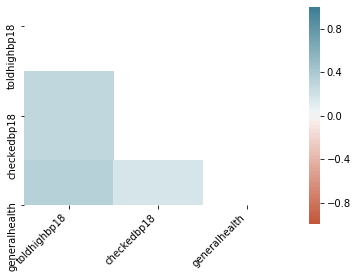

In [157]:
df_train_cardio=df_train_cardio.dropna()
corr_cardio = df_train_cardio.corr().abs()
draw_corr(corr_cardio)
corr_cardio.unstack().sort_values(kind="quicksort")

# Cardio vs General Health


In [347]:
df_train_cardio=df_train_cardio[["toldhighbp18","checkedbp18","generalhealth"]]
df_train_cardio=df_train_cardio.dropna()
#preparing training and test data
x=df_train_cardio[["toldhighbp18","checkedbp18"]] #source feature
y=df_train_cardio[["generalhealth"]] #target feature
# algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=1.1484
# model = GaussianNB() #rmse=1.28
model_apply(x,y,3,2)

[0.64278728 0.35721272]
Predicted Value: [2. 2. 3. ... 4. 2. 4.]
Accuracy: 0.33480352846832395
[[  0 265 121  22   0]
 [  0 382 173  93   0]
 [  0 328 283 151   0]
 [  0 157 200 170   0]
 [  0  22  55  72   0]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       408
         2.0       0.33      0.59      0.42       648
         3.0       0.34      0.37      0.36       762
         4.0       0.33      0.32      0.33       527
         5.0       0.00      0.00      0.00       149

    accuracy                           0.33      2494
   macro avg       0.20      0.26      0.22      2494
weighted avg       0.26      0.33      0.29      2494



/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


1.1483749544842086

# Checking correlation between Diabetes data

In [168]:
df_train_diabetes=df[["diabetes18","insulin","takingdiabpill18","takingdiabinject","generalhealth"]]
print(df_train_diabetes.head())
df_train_diabetes.isnull().sum()

   diabetes18  insulin  takingdiabpill18  takingdiabinject  generalhealth
0         2.0      NaN               NaN               NaN            2.0
1         2.0      NaN               NaN               NaN            2.0
2         2.0      NaN               NaN               NaN            4.0
3         2.0      NaN               NaN               NaN            2.0
4         2.0      NaN               NaN               NaN            3.0


diabetes18            18
insulin             8524
takingdiabpill18    8522
takingdiabinject    8533
generalhealth         46
dtype: int64

As "insulin","takingdiabpill18","takingdiabinject" have mostly NA values we have to drop them. Since only one column is left there is no need to check correlation here.

# Diabetes vs General Health 

In [233]:
df_train_diabetes=df_train_diabetes[["diabetes18","generalhealth"]]
df_train_diabetes=df_train_diabetes.dropna()
#preparing training and test data
x=df_train_diabetes[["diabetes18"]] #source feature
y=df_train_diabetes[["generalhealth"]] #target feature
# algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=1.1323
# model = GaussianNB() #rmse=1.28
model_apply(x,y,3,1)

[1.]
Predicted Value: [3. 3. 4. ... 4. 3. 3.]
Accuracy: 0.33200159808230123
[[  0   0 364  14   0]
 [  0   0 661  36   0]
 [  0   0 672 114   0]
 [  0   0 345 159   0]
 [  0   0  75  63   0]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       378
         2.0       0.00      0.00      0.00       697
         3.0       0.32      0.85      0.46       786
         4.0       0.41      0.32      0.36       504
         5.0       0.00      0.00      0.00       138

    accuracy                           0.33      2503
   macro avg       0.15      0.23      0.16      2503
weighted avg       0.18      0.33      0.22      2503



/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


1.1322815578152803

# Clubbing the different parameters

In [325]:
df_clubbed=df[["cid","exercise18","cyclingfreq","diabetes18",
               "toldhighbp18","nutrition46","nutrition47","ssb",
              "generalhealth"]]
print(df_clubbed.head())
df_clubbed.isnull().sum()

       cid  exercise18  cyclingfreq  diabetes18  toldhighbp18  nutrition46  \
0  1900001         1.0          2.0         2.0           1.0          2.0   
1  1900002         1.0          5.0         2.0           2.0          1.0   
2  1900003         1.0          5.0         2.0           2.0          1.0   
3  1900004         1.0          5.0         2.0           2.0          1.0   
4  1900005         2.0          2.0         2.0           2.0          0.0   

   nutrition47  ssb  generalhealth  
0          1.0  2.0            2.0  
1          1.0  1.0            2.0  
2          2.0  2.0            4.0  
3          1.0  2.0            2.0  
4          2.0  2.0            3.0  


cid                0
exercise18        21
cyclingfreq       26
diabetes18        18
toldhighbp18      31
nutrition46      186
nutrition47      233
ssb              115
generalhealth     46
dtype: int64

In [357]:
df_clubbed=df_clubbed.dropna()
#preparing training and test data
x=df_clubbed.drop(columns=["cid","generalhealth"]) #source feature
y=df_clubbed[["generalhealth"]] #target feature
# algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=1.1430, with pca 1.058
# algo=svm.SVC(gamma='scale') #emse=1.1806
# algo = GaussianNB() #rmse=1.2156
# algo=DecisionTreeClassifier() #rmse=1.4330


In [367]:


model_apply(x,y,3,6)

[0.25271258 0.18353315 0.1311358  0.13020431 0.11024677 0.1044609 ]
Predicted Value: [2. 3. 3. ... 2. 3. 2.]
Accuracy: 0.3426895684960201
[[ 74 145 168  20   3]
 [ 73 224 264  52   1]
 [ 54 189 382 101   8]
 [ 26  88 226 132   9]
 [  2  16  74  50   6]]
              precision    recall  f1-score   support

         1.0       0.32      0.18      0.23       410
         2.0       0.34      0.36      0.35       614
         3.0       0.34      0.52      0.41       734
         4.0       0.37      0.27      0.32       481
         5.0       0.22      0.04      0.07       148

    accuracy                           0.34      2387
   macro avg       0.32      0.28      0.28      2387
weighted avg       0.34      0.34      0.33      2387



1.2074340320563726

#### Physical Activity vs Cardio Health

In [212]:
#preparing training and test data
x=df_clubbed[["exercise18","cyclingfreq"]] #source feature
y=df_clubbed[["toldhighbp18"]] #target feature
# algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=0.5932
# algo=svm.SVC(gamma='scale') #emse=1.1806
# algo = GaussianNB() #rmse=1.2156
# algo=DecisionTreeClassifier() #rmse=1.4330
model_apply(x,y,3,1)

[0.58218436]
Predicted Value: [2. 2. 2. ... 2. 2. 2.]
Accuracy: 0.6480938416422287
[[  24  829]
 [  11 1523]]
              precision    recall  f1-score   support

         1.0       0.69      0.03      0.05       853
         2.0       0.65      0.99      0.78      1534

    accuracy                           0.65      2387
   macro avg       0.67      0.51      0.42      2387
weighted avg       0.66      0.65      0.52      2387



0.5932167886681659

# Nutrition vs Cardio Health

In [316]:
#preparing training and test data
x=df_clubbed[["nutrition46","nutrition47","ssb"]] #source feature
y=df_clubbed[["toldhighbp18"]] #target feature
# algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=0.5978 DT: 0.6023
# algo=svm.SVC(gamma='scale') #emse=1.1806
# algo = GaussianNB() #rmse=1.2156
# algo=DecisionTreeClassifier() #rmse=1.4330
model_apply(x,y,3,1)

[0.48825148]
Predicted Value: [2. 2. 2. ... 2. 2. 2.]
Accuracy: 0.6372015081692501
[[  11  842]
 [  24 1510]]
              precision    recall  f1-score   support

         1.0       0.31      0.01      0.02       853
         2.0       0.64      0.98      0.78      1534

    accuracy                           0.64      2387
   macro avg       0.48      0.50      0.40      2387
weighted avg       0.52      0.64      0.51      2387



0.6023275619052725

# Physical vs Diabetes

In [244]:
#preparing training and test data
x=df_clubbed[["exercise18","cyclingfreq"]] #source feature
y=df_clubbed[["diabetes18"]] #target feature
# algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=0.3937 DT=0.3953
# algo=svm.SVC(gamma='scale') #emse=1.1806
# algo = GaussianNB() #rmse=1.2156
# algo=DecisionTreeClassifier() #rmse=1.4330
model_apply(x,y,3,1)

[0.58218436]
Predicted Value: [2. 2. 2. ... 2. 2. 2.]
Accuracy: 0.8437369082530373
[[   7  363]
 [  10 2007]]
              precision    recall  f1-score   support

         1.0       0.41      0.02      0.04       370
         2.0       0.85      1.00      0.91      2017

    accuracy                           0.84      2387
   macro avg       0.63      0.51      0.48      2387
weighted avg       0.78      0.84      0.78      2387



0.3953012670697663

# Nutrition vs Diabetes

In [253]:
#preparing training and test data
x=df_clubbed[["nutrition46","nutrition47","ssb"]] #source feature
y=df_clubbed[["diabetes18"]] #target feature
# algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=0.3937 DT=0.3966
# algo=svm.SVC(gamma='scale') #emse=1.1806
# algo = GaussianNB() #rmse=1.2156
# algo=DecisionTreeClassifier() #rmse=1.4330
model_apply(x,y,3,1)

[0.48825148]
Predicted Value: [2. 2. 2. ... 2. 2. 2.]
Accuracy: 0.8428990364474236
[[   0  370]
 [   5 2012]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       370
         2.0       0.84      1.00      0.91      2017

    accuracy                           0.84      2387
   macro avg       0.42      0.50      0.46      2387
weighted avg       0.71      0.84      0.77      2387



0.3963596391568855

We observed that most of the Diabetes predictions are of class 2. Probably there is an imbalace of class in test data. Let us check.

# Resampling Diabetese Dataset

In [254]:
#[1]https://elitedatascience.com/imbalanced-classes
df_clubbed["diabetes18"].value_counts()

2.0    8082
1.0    1464
Name: diabetes18, dtype: int64

As we can see that class 2 has more samples than class 1 which shows that data is impbalanced and fovours class 2. Upsampling the class 1 data :

# Up Sampling

In [255]:
from sklearn.utils import resample
# Separate majority and minority classes
df_majority = df_clubbed[df_clubbed.diabetes18==2]
df_minority = df_clubbed[df_clubbed.diabetes18==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=8082,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.diabetes18.value_counts()

1.0    8082
2.0    8082
Name: diabetes18, dtype: int64

# Nutrition vs Diabetes again after upsampling

In [262]:
#preparing training and test data
x=df_upsampled[["nutrition46","nutrition47","ssb"]] #source feature
y=df_upsampled[["diabetes18"]] #target feature
# algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=0.6678 DT=0.6588
# algo=svm.SVC(gamma='scale') #emse=1.1806
# algo = GaussianNB() #rmse=1.2156
# algo=DecisionTreeClassifier() #rmse=1.4330
model_apply(x,y,3,1)

[0.44936878]
Predicted Value: [1. 2. 2. ... 2. 2. 1.]
Accuracy: 0.5659490225191784
[[1293  766]
 [ 988  994]]
              precision    recall  f1-score   support

         1.0       0.57      0.63      0.60      2059
         2.0       0.56      0.50      0.53      1982

    accuracy                           0.57      4041
   macro avg       0.57      0.56      0.56      4041
weighted avg       0.57      0.57      0.56      4041



0.6588254529697692

# Physical Activity vs Diabetes after upsampling

In [312]:
#preparing training and test data
x=df_upsampled[["exercise18","cyclingfreq"]] #source feature
y=df_upsampled[["diabetes18"]] #target feature
# algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=0.6735 DT=0.6566
# algo=svm.SVC(gamma='scale') #emse=1.1806
# algo = GaussianNB() #rmse=1.2156
# algo=DecisionTreeClassifier() #rmse=1.4330
model_apply(x,y,3,1)

[0.56551363]
Predicted Value: [1. 1. 1. ... 1. 1. 1.]
Accuracy: 0.568918584508785
[[1862  197]
 [1545  437]]
              precision    recall  f1-score   support

         1.0       0.55      0.90      0.68      2059
         2.0       0.69      0.22      0.33      1982

    accuracy                           0.57      4041
   macro avg       0.62      0.56      0.51      4041
weighted avg       0.62      0.57      0.51      4041



0.6565679062299764

# Down Sampling

In [270]:
#Down Sampling
df_majority = df_clubbed[df_clubbed.diabetes18==2]
df_minority = df_clubbed[df_clubbed.diabetes18==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=1464,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.diabetes18.value_counts()

1.0    1464
2.0    1464
Name: diabetes18, dtype: int64

# Nutrition vs Diabetes again after down sampling

In [308]:
#preparing training and test data
x=df_downsampled[["nutrition46","nutrition47","ssb"]] #source feature
y=df_downsampled[["diabetes18"]] #target feature
# algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=0.6735 with Logistic=0.657
# algo=svm.SVC(gamma='scale') #emse=1.1806
# algo = GaussianNB() #rmse=1.2156
# algo=DecisionTreeClassifier() #rmse=1.4330
model_apply(x,y,3,2)

[0.47692086 0.37183809]
Predicted Value: [2. 2. 2. 1. 1. 1. 2. 1. 1. 1. 2. 1. 1. 2. 1. 1. 1. 2. 2. 2. 1. 1. 2. 2.
 1. 1. 1. 2. 2. 1. 1. 2. 1. 2. 2. 2. 1. 2. 1. 1. 1. 1. 1. 1. 1. 2. 1. 2.
 2. 1. 1. 1. 2. 1. 2. 2. 1. 1. 2. 1. 1. 2. 2. 2. 1. 1. 1. 1. 2. 1. 1. 2.
 2. 2. 2. 2. 2. 1. 2. 1. 1. 1. 1. 2. 1. 2. 2. 1. 2. 2. 1. 2. 1. 1. 1. 2.
 1. 2. 2. 2. 1. 2. 1. 1. 2. 1. 2. 1. 2. 1. 1. 1. 1. 1. 2. 1. 2. 1. 1. 1.
 1. 1. 1. 2. 2. 2. 2. 1. 1. 2. 1. 2. 1. 2. 1. 1. 1. 1. 2. 2. 1. 2. 2. 1.
 2. 1. 1. 2. 2. 1. 2. 2. 1. 1. 1. 2. 1. 2. 1. 1. 1. 1. 1. 2. 1. 2. 2. 2.
 1. 1. 1. 2. 1. 1. 1. 2. 1. 1. 1. 1. 2. 1. 2. 2. 1. 1. 1. 1. 1. 2. 1. 1.
 2. 1. 2. 1. 2. 2. 1. 1. 1. 1. 1. 2. 1. 1. 2. 1. 1. 2. 1. 1. 2. 1. 1. 2.
 1. 2. 2. 1. 2. 1. 1. 2. 1. 1. 2. 1. 2. 2. 2. 2. 1. 2. 1. 2. 1. 2. 1. 2.
 1. 1. 2. 2. 1. 2. 1. 1. 2. 1. 1. 2. 1. 2. 1. 2. 1. 2. 2. 2. 2. 2. 1. 1.
 2. 1. 2. 2. 1. 1. 1. 1. 2. 1. 1. 2. 2. 2. 1. 2. 1. 1. 1. 2. 1. 1. 1. 1.
 1. 2. 1. 2. 1. 1. 2. 2. 1. 1. 1. 2. 1. 1. 2. 1. 1. 2. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 

0.6825298488238585

# Physical Activity vs Diabetes after down sampling

In [293]:
#preparing training and test data
x=df_downsampled[["exercise18","cyclingfreq"]] #source feature
y=df_downsampled[["diabetes18"]] #target feature
# algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=0.6735 DT=0.6683
# algo=svm.SVC(gamma='scale') #emse=1.1806
# algo = GaussianNB() #rmse=1.2156
# algo=DecisionTreeClassifier() #rmse=1.4330
model_apply(x,y,3,1)

[0.60119497]
Predicted Value: [2. 1. 2. 1. 1. 2. 1. 1. 2. 2. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1.
 1. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 2. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 2. 2. 2. 1. 1. 1. 2. 1. 2. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 2. 2. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1.
 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 2. 2. 1. 1. 2. 1. 1. 1. 2. 1. 2. 1. 2. 1.
 1. 1. 1. 2. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 2. 1. 1. 2. 1.
 1. 2. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 2. 2. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1.
 2. 1. 1. 2. 1. 1. 1. 2. 2. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1.

0.6683721354720062

After both Up and Down sampling the rmse is near about remains 0.67

# Martial Status vs Cardio Vascular Health

In [294]:
df_martial=df[["maritalstatus18","toldhighbp18","generalhealth"]]
df_martial=df_martial.dropna()

In [299]:
#preparing training and test data
x=df_martial[["maritalstatus18"]] #source feature
y=df_martial[["toldhighbp18"]] #target feature
# algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=0.5821 DT=0.5562
# algo=svm.SVC(gamma='scale') #emse=1.1806
# algo = GaussianNB() #rmse=1.2156
# algo=DecisionTreeClassifier() #rmse=1.4330
model_apply(x,y,3,1)

[1.]
Predicted Value: [2. 2. 2. ... 2. 2. 2.]
Accuracy: 0.6906300484652665
[[ 152  687]
 [  79 1558]]
              precision    recall  f1-score   support

         1.0       0.66      0.18      0.28       839
         2.0       0.69      0.95      0.80      1637

    accuracy                           0.69      2476
   macro avg       0.68      0.57      0.54      2476
weighted avg       0.68      0.69      0.63      2476



0.5562103482808761

# Marital Status vs General Health Status

In [307]:
#preparing training and test data
x=df_martial[["maritalstatus18"]] #source feature
y=df_martial[["generalhealth"]] #target feature
# algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=1.1592
# algo=svm.SVC(gamma='scale') #emse=1.1806
# algo = GaussianNB() #rmse=1.2156
# algo=DecisionTreeClassifier() #rmse=1.4330
model_apply(x,y,3,1)

[1.]
Predicted Value: [3. 3. 3. ... 3. 3. 3.]
Accuracy: 0.3033117932148627
[[  0   0 379  12   0]
 [  0   0 650  18   0]
 [  0   0 712  48   0]
 [  0   0 472  39   0]
 [  0   0 134  12   0]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       391
         2.0       0.00      0.00      0.00       668
         3.0       0.30      0.94      0.46       760
         4.0       0.30      0.08      0.12       511
         5.0       0.00      0.00      0.00       146

    accuracy                           0.30      2476
   macro avg       0.12      0.20      0.12      2476
weighted avg       0.16      0.30      0.17      2476



/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


1.174238831585204